In [13]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct  # Import DCT from scipy
import librosa  # Ensure librosa is imported for loading audio files

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def pre_emphasis(signal, alpha=0.97):
    """Apply pre-emphasis filter."""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_size)) / hop_size)) + 1
    pad_signal_length = num_frames * hop_size + frame_size
    z = np.zeros(pad_signal_length)
    z[:len(signal)] = signal
    
    frames = np.lib.stride_tricks.as_strided(z,
        shape=(num_frames, frame_size),
        strides=(z.strides[0] * hop_size, z.strides[0])).copy()
    
    return frames

def hamming_window(frame):
    """Apply Hamming window to a frame."""
    return np.hamming(len(frame)) * frame

def mel_filter_bank(num_filters, fft_size, sample_rate, low_freq=0, high_freq=None):
    """Create a Mel filter bank."""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # Convert frequency to Mel scale
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(fft_size / 2 + 1))))
    
    for n in range(1, num_filters + 1):
        filters[n - 1, bin_points[n - 1]:bin_points[n]] = \
            (np.arange(bin_points[n - 1], bin_points[n]) - bin_points[n - 1]) / (bin_points[n] - bin_points[n - 1])
        filters[n - 1, bin_points[n]:bin_points[n + 1]] = \
            (bin_points[n + 1] - np.arange(bin_points[n], bin_points[n + 1])) / (bin_points[n + 1] - bin_points[n])
    
    return filters

def compute_mfcc(signal, sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=160):
    """Compute MFCC from scratch."""
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, n_fft, hop_length)

    # Step 3: Apply Hamming window
    windowed_frames = np.array([hamming_window(frame) for frame in frames])

    # Step 4: FFT and Power Spectrum
    mag_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft)) ** 2

    # Step 5: Mel Filter Bank
    mel_filters = mel_filter_bank(n_mfcc, n_fft, sample_rate)
    
    # Step 6: Apply Mel filter bank to power spectrum
    mel_energies = np.dot(mag_frames, mel_filters.T)

    # Step 7: Logarithm of Mel energies
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)

    # Step 8: Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_energies, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

def load_data_with_mfcc(directory, n_mfcc=13, n_fft=400, hop_size=160, target_length=16000):
    """Load data from a directory and extract MFCC features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    audio_length = len(signal)  # Length in samples
                    mfcc = compute_mfcc(signal, sample_rate=rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_size)
                    num_frames = mfcc.shape[1]

                    # Check if the first window is less than 25 ms (400 samples)
                    if num_frames > 0 and (num_frames * hop_size < 400):  
                        print(f"Stopping processing for {file_name}: first window is less than 30 ms.")
                        break
                    
                    X.append(mfcc)
                    y.append(label_map[label])
                    
                    # Display number of frames and audio length for each sample
                    #print(f"File: {file_name}, Label: {label}, Audio Length: {audio_length} samples, Number of frames: {num_frames}")

                    # Print total number of windows for each file
                    #print(f"Total number of windows for {file_name}: {num_frames}")

                    # Print shape of the feature vector (MFCC matrix)
                    #print(f"MFCC feature vector shape for {file_name}: {mfcc.shape}")

            else:
                continue  
            break  

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)  
    print("Labels array shape:", y.shape)

    return X, y, labels


# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_with_mfcc(directory)

# Reshape X for CNN input (add channel dimension if needed)
if X.size > 0:
   X = X[:, :, :]  




Feature array shape: (27692, 99, 13)
Labels array shape: (27692,)


## (32,64)

In [15]:
# Section 2: CNN Model Definition
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.25)

        conv_out_size = self._get_conv_out(input_shape)
        self.fc1 = nn.Linear(conv_out_size, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_out(self, shape):
        o = torch.zeros(1, *shape)
        o = self.pool1(self.conv1(o))
        o = self.pool2(self.conv2(o))
        return int(np.prod(o.size()))

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

## (64,128)

In [3]:
import torch
import torch.nn as nn
import numpy as np

# Section 2: CNN Model Definition
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.25)

        conv_out_size = self._get_conv_out(input_shape)
        self.fc1 = nn.Linear(conv_out_size, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_out(self, shape):
        o = torch.zeros(1, *shape)
        o = self.pool1(self.conv1(o))
        o = self.pool2(self.conv2(o))
        return int(np.prod(o.size()))

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x


## (128,256)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.25)

        conv_out_size = self._get_conv_out(input_shape)
        self.fc1 = nn.Linear(conv_out_size, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_out(self, shape):
        o = torch.zeros(1, *shape)
        o = self.pool1(self.conv1(o))
        o = self.pool2(self.conv2(o))
        return int(np.prod(o.size()))

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [16]:
# Section 3: Data Loading and Preprocessing


# Reshape X for CNN input (add channel dimension)
X = X[:, np.newaxis, :, :]  # (samples, channels, n_mfcc, max_len)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create PyTorch Datasets and DataLoaders
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch 1/150, Loss: 1.6604
Epoch 2/150, Loss: 1.0987
Epoch 3/150, Loss: 0.9427
Epoch 4/150, Loss: 0.8650
Epoch 5/150, Loss: 0.7974
Epoch 6/150, Loss: 0.7670
Epoch 7/150, Loss: 0.7341
Epoch 8/150, Loss: 0.7041
Epoch 9/150, Loss: 0.6910
Epoch 10/150, Loss: 0.6573
Epoch 11/150, Loss: 0.6424
Epoch 12/150, Loss: 0.6187
Epoch 13/150, Loss: 0.6130
Epoch 14/150, Loss: 0.5940
Epoch 15/150, Loss: 0.5783
Epoch 16/150, Loss: 0.5727
Epoch 17/150, Loss: 0.5567
Epoch 18/150, Loss: 0.5499
Epoch 19/150, Loss: 0.5448
Epoch 20/150, Loss: 0.5285
Epoch 21/150, Loss: 0.5299
Epoch 22/150, Loss: 0.5197
Epoch 23/150, Loss: 0.5051
Epoch 24/150, Loss: 0.5034
Epoch 25/150, Loss: 0.4959
Epoch 26/150, Loss: 0.4901
Epoch 27/150, Loss: 0.4856
Epoch 28/150, Loss: 0.4786
Epoch 29/150, Loss: 0.4607
Epoch 30/150, Loss: 0.4717
Epoch 31/150, Loss: 0.4581
Epoch 32/150, Loss: 0.4681
Epoch 33/150, Loss: 0.4492
Epoch 34/150, Loss: 0.4496
Epoch 35/150, Loss: 0.4532
Epoch 36/150, Loss: 0.4378
Epoch 37/150, Loss: 0.4336
Epoch 38/1

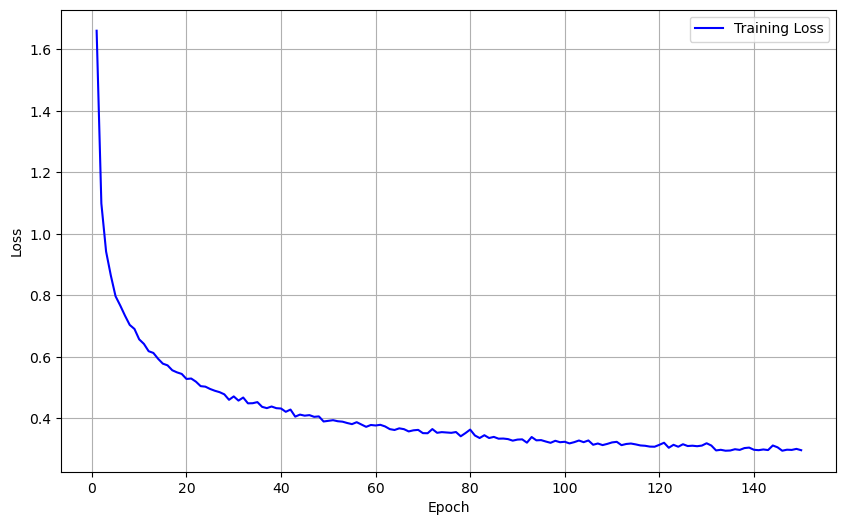

In [17]:
import matplotlib.pyplot as plt

# Section 4: Model Training
device = torch.device("cpu")  # Force CPU usage

input_shape = (1, 13, 99)  # (channels, n_mfcc, max_len)
num_classes = len(labels)
model = CNNModel(input_shape, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 150
loss_history = []  # To store loss for each epoch

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)  # Append epoch loss to history
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

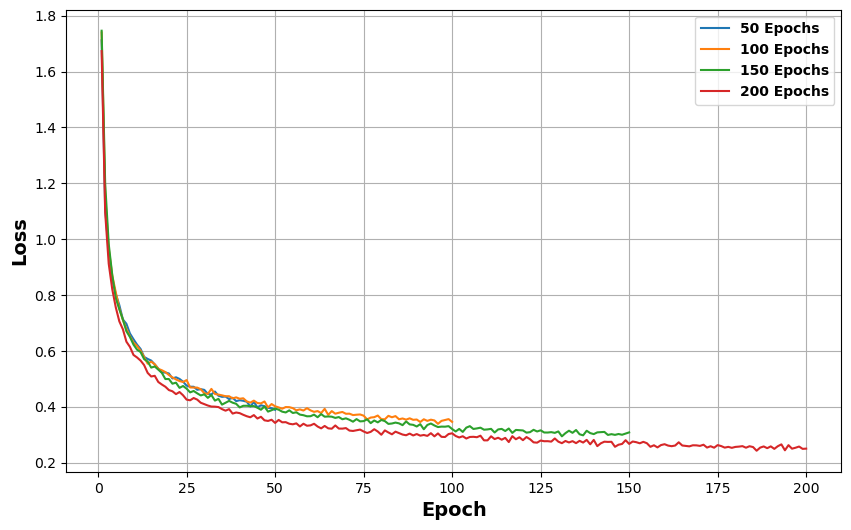

In [6]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Section 4: Model Training
device = torch.device("cpu")  # Force CPU usage

input_shape = (1, 13, 99)  # (channels, n_mfcc, max_len)
num_classes = len(labels)
model = CNNModel(input_shape, num_classes).to(device)

# Placeholder for training loop - just an example for clarity
epochs_list = [50, 100, 150, 200]
loss_history_dict = {}

for epochs in epochs_list:
    loss_history = []  # To store loss for each epoch
    
    # Re-initialize the model, criterion, and optimizer for each run
    model = CNNModel(input_shape, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)  # Append epoch loss to history

    loss_history_dict[epochs] = loss_history

# Plot training loss for different epochs
plt.figure(figsize=(10, 6))

# Plot for each epoch count
for epochs in epochs_list:
    plt.plot(range(1, epochs + 1), loss_history_dict[epochs], label=f'{epochs} Epochs')

plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.legend(prop={'weight': 'bold'})
plt.grid()
plt.savefig('cnn_training_loss.png', bbox_inches='tight')
plt.show()


In [18]:
# Section 5: Evaluation
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1:.5f}")
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=labels))

# Map for labels
print("Label mapping:", {idx: label for label, idx in enumerate(labels)})


Accuracy: 0.90143
Precision: 0.90550
Recall: 0.90143
F1 Score: 0.90171
Classification Report:
               precision    recall  f1-score   support

        down       0.84      0.87      0.85       445
          go       0.82      0.92      0.86       486
        left       0.96      0.88      0.92       479
          no       0.96      0.87      0.91       510
         off       0.88      0.85      0.87       473
          on       0.90      0.93      0.92       491
       right       0.97      0.94      0.95       465
     silence       0.97      1.00      0.99       383
        stop       0.95      0.94      0.94       445
     unknown       0.88      0.75      0.81       427
          up       0.77      0.93      0.84       480
         yes       0.96      0.96      0.96       455

    accuracy                           0.90      5539
   macro avg       0.91      0.90      0.90      5539
weighted avg       0.91      0.90      0.90      5539

Label mapping: {'down': 0, 'go': 1, 'l

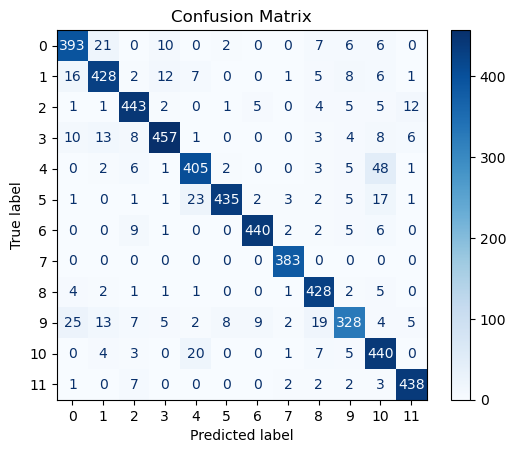

In [7]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig('cnn_confusion_matrix.png', bbox_inches='tight')
plt.show()

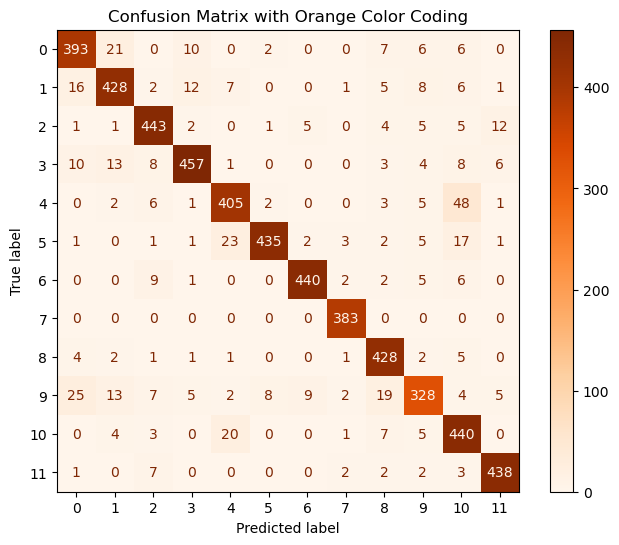

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.colors as mcolors

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define an orange colormap
cmap = plt.cm.Oranges  # Matches your provided image

# Normalize the matrix to scale colors appropriately
norm = mcolors.Normalize(vmin=0, vmax=np.max(cm))  # Normalizes based on max value

# Create and plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap, ax=ax, values_format='d')

# Update title
plt.title("Confusion Matrix with Orange Color Coding")

# Save and show plot
plt.savefig('cnn_confusion_matrix_orange.png', bbox_inches='tight')
plt.show()


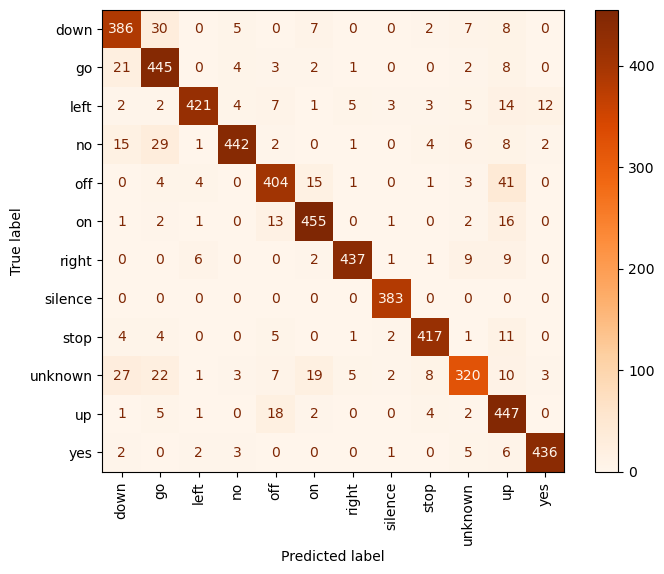

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.colors as mcolors

# Class label mapping
class_labels = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 
                'silence', 'stop', 'unknown', 'up', 'yes']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define an orange colormap
cmap = plt.cm.Oranges  # Matches your provided image

# Normalize the matrix to scale colors appropriately
norm = mcolors.Normalize(vmin=0, vmax=np.max(cm))  # Normalizes based on max value

# Create and plot confusion matrix with labels
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=cmap, ax=ax, values_format='d')

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Update title
#plt.title("Confusion Matrix with Orange Color Coding")

# Save and show plot
plt.savefig('cnn_confusion_matrix_32,64.png', bbox_inches='tight')
plt.show()
